# ResNet50 Transfer Learning Classifier — *Human* vs *Avatar* vs *Animal*

**Why ResNet50?**
- **Residual connections** make deep networks easier to optimize and reduce degradation as depth increases (the “skip‑connections” idea). This lets us use a strong feature extractor without struggling with vanishing gradients.  
- **Proven transfer learning performance**: ResNet50 pre‑trained on ImageNet provides rich, general‑purpose visual features that adapt well to small/medium custom datasets (like profile photos).  
- **Balanced accuracy vs. speed**: Compared to much larger backbones, ResNet50 is fast enough for iteration and deployment while still offering high accuracy.  
- **Fine‑tuning friendly**: Note, fine tuning is not implemented, but we could implement it later by unfreezing upper blocks and fitting the model.

We’ll train a 3‑class classifier for ['human', 'avatar', 'animal'] using **transfer learning + fine‑tuning**. The notebook:
1. Uses an existing split under**data/final/{train,val,test}/{human,avatar,animal}**.
2. Visualizes class distribution and sample images for each split.
3. Builds a performant **tf.data** pipeline with caching/prefetching and on‑the‑fly **data augmentation** for training only.
4. Trains a **ResNet50** backbone, tracks metrics, and plots learning curves.
5. Evaluates on the **test set**, prints a classification report & confusion matrix.
6. Shows 24 test images with the true label, predicted label (bold), and per‑class probabilities.

**Ethical notes & bias**: We have used FairFace dataset to try to avoid bias when processing images. This pipeline supports class weighting and extensible auditing hooks to help reduce skew from label imbalance.

**References & Further Reading**
1. He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep Residual Learning for Image Recognition* (ResNet). CVPR 2016 / arXiv:1512.03385.  
   https://arxiv.org/abs/1512.03385  
2. TensorFlow / Keras ResNet50 API docs — tf.keras.applications.ResNet50:  
   https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50
3. TensorFlow Transfer Learning & Fine‑Tuning tutorial:  
   https://www.tensorflow.org/tutorials/images/transfer_learning
4. tf.data performance guide (caching, prefetch, AUTOTUNE):  
   https://www.tensorflow.org/guide/data_performance
5. Keras Applications overview (pre‑trained weights & preprocessing):  
   https://keras.io/api/applications/
6. Keras image dataset utilities (directory loading, formats):  
   https://keras.io/api/data_loading/image/

## Load data from Google Drive

If we are running in Colab, mount Google Drive to retrieve the dataset stored there. If we are running in Docker, we assume the dataset is already present.

In [104]:
from pathlib import Path
import shutil
import sys
import os

DEST_DIR = Path('data/final')

if 'google.colab' in sys.modules:
    print("Running in Google Colab.")

    if not DEST_DIR.exists():
        from google.colab import drive

        drive.mount('/content/drive')

        SOURCE_DIR = Path('/content/drive/My Drive/Colab Data/Capstone/final')

        print(f"Copying data from {SOURCE_DIR} to {DEST_DIR}...")
        shutil.copytree(SOURCE_DIR, DEST_DIR)
        print("Copy complete.")
    else:
        print(f"Destination directory {DEST_DIR} already exists. Skipping data loading from Google Drive.")
else:
    print("Probably running in Docker.")
    assert not DEST_DIR.exists(), f"Missing or empty: {DEST_DIR}"
    print(f"Dataset found at {DEST_DIR}.")

Running in Google Colab.
Destination directory data/final already exists. Skipping data loading from Google Drive.


## Imports & configuration

This cell imports necessary libraries for data manipulation, visualization, and building the deep learning model. It also sets up configuration parameters like random seeds for reproducibility, paths to the data, class names, image size, batch size, and training epochs.

Mixed precision is optionally enabled to use a combination of float16 and float32 data types during training. This can lead to significant speedups and reduced memory usage on compatible hardware without sacrificing much accuracy. This was necessary to speed up the execution on my PC with a GPU. Not necessary in Colab.

(see: [Tensorflow - Mixed Precision](https://www.tensorflow.org/guide/mixed_precision))


In [105]:
import os, math, random, json, itertools, time
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mixed precision (optional)
USE_MIXED_PRECISION = False # Necessary on Docker on my PC with a GPU.
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")

# Paths & constants
DATA_ROOT = Path("data") / "final"   # expects train/, val/, test/ each with human/, avatar/, animal/
SPLITS = ["train", "val", "test"]
CLASS_NAMES = ['human', 'avatar', 'animal']
IMG_SIZE = (224, 224)
BATCH_SIZE = 32        # A common starting point. May work in Colab but not in Docker.
EPOCHS = 15            # May be too many but early stopping will not let us get this far unless necessary.

# Verify structure exists
for split in SPLITS:
    for cname in CLASS_NAMES:
        cpath = DATA_ROOT / split / cname
        assert cpath.exists() and any(cpath.glob("*")), f"Missing or empty: {cpath}"

print("Found expected directory structure under data/final")

# Notebook timing start
from datetime import datetime
RUN_START_DT = datetime.now()
RUN_START_T = time.perf_counter()


Found expected directory structure under data/final


## Resize if needed function

This function takes an image and a target size, and resizes the image using **tf.image.resize_with_pad** only if its current dimensions do not match the target size. It also ensures the output tensor has a static shape hint for downstream layers.

(see: [Tensorflow - tf.image.resize_with_pad API](https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad) and [Tensorflow - tf.cond API](https://www.tensorflow.org/api_docs/python/tf/cond))

In [106]:
def resize_if_needed(image, size):
    # Ensure known channel dim
    image = tf.ensure_shape(image, [None, None, 3])
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    target_h = tf.cast(size[0], tf.int32)
    target_w = tf.cast(size[1], tf.int32)

    def do_resize():
        return tf.cast(tf.image.resize_with_pad(image, int(size[0]), int(size[1])), tf.float32)

    def skip():
        return tf.cast(image, tf.float32)

    out = tf.cond(tf.logical_and(tf.equal(h, target_h), tf.equal(w, target_w)), skip, do_resize)
    # After tf.cond, set static shape to help downstream layers
    out.set_shape((int(size[0]), int(size[1]), 3))
    return out

## Discover files from existing splits

This cell defines a function to find image paths and corresponding labels within the specified data splits (train, validation, and test) based on the class names. It then uses this function to collect the paths and labels for each split and prints the counts for verification.

In [107]:
def find_images_split(base_split_dir: Path, class_names):
    paths, labels = [], []
    for idx, cname in enumerate(class_names):
        for p in sorted((base_split_dir / cname).rglob("*")):
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"} and p.is_file():
                paths.append(str(p))
                labels.append(idx)
    return np.array(paths), np.array(labels)

train_paths, train_labels = find_images_split(DATA_ROOT / "train", CLASS_NAMES)
val_paths,   val_labels   = find_images_split(DATA_ROOT / "val",   CLASS_NAMES)
test_paths,  test_labels  = find_images_split(DATA_ROOT / "test",  CLASS_NAMES)

print(f"Counts — train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")
for name, labels in [("train", train_labels), ("val", val_labels), ("test", test_labels)]:
    counts = Counter(labels)
    print(name, {CLASS_NAMES[i]: int(counts.get(i, 0)) for i in range(len(CLASS_NAMES))})

Counts — train: 24000, val: 3000, test: 3000
train {'human': 8000, 'avatar': 8000, 'animal': 8000}
val {'human': 1000, 'avatar': 1000, 'animal': 1000}
test {'human': 1000, 'avatar': 1000, 'animal': 1000}


## Plot class distribution for each split

Define a function to show the distribution of classes within each dataset split (train, validation, and test) using bar plots. This helps to understand if the dataset is balanced or imbalanced across the classes.

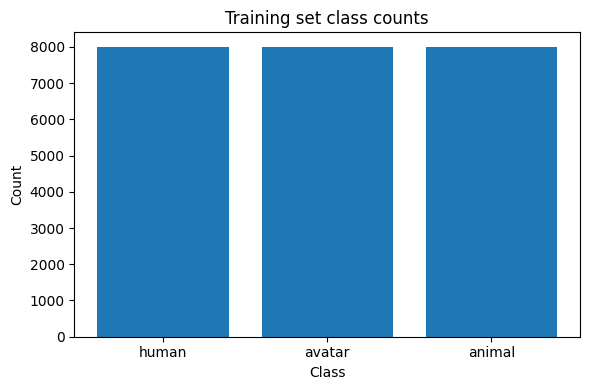

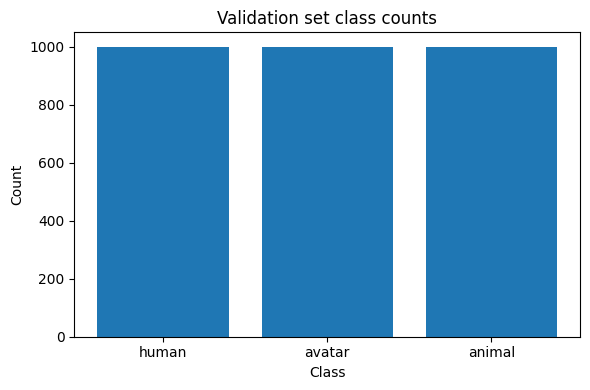

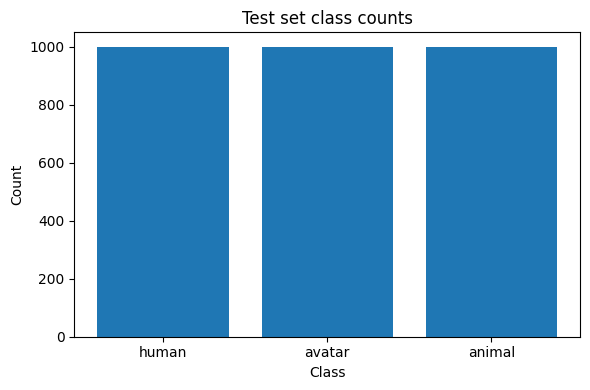

In [108]:
def plot_class_distribution(labels, title):
    counts = Counter(labels)
    xs = list(range(len(CLASS_NAMES)))
    ys = [counts.get(i, 0) for i in xs]
    plt.figure(figsize=(6,4))
    plt.bar([CLASS_NAMES[i] for i in xs], ys)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_labels, "Training set class counts")
plot_class_distribution(val_labels,   "Validation set class counts")
plot_class_distribution(test_labels,  "Test set class counts")

## Show a few training images

Define a function to display a random sample of images from a given set of paths and labels. This is useful for visually inspecting the data and ensuring the images are loaded correctly.

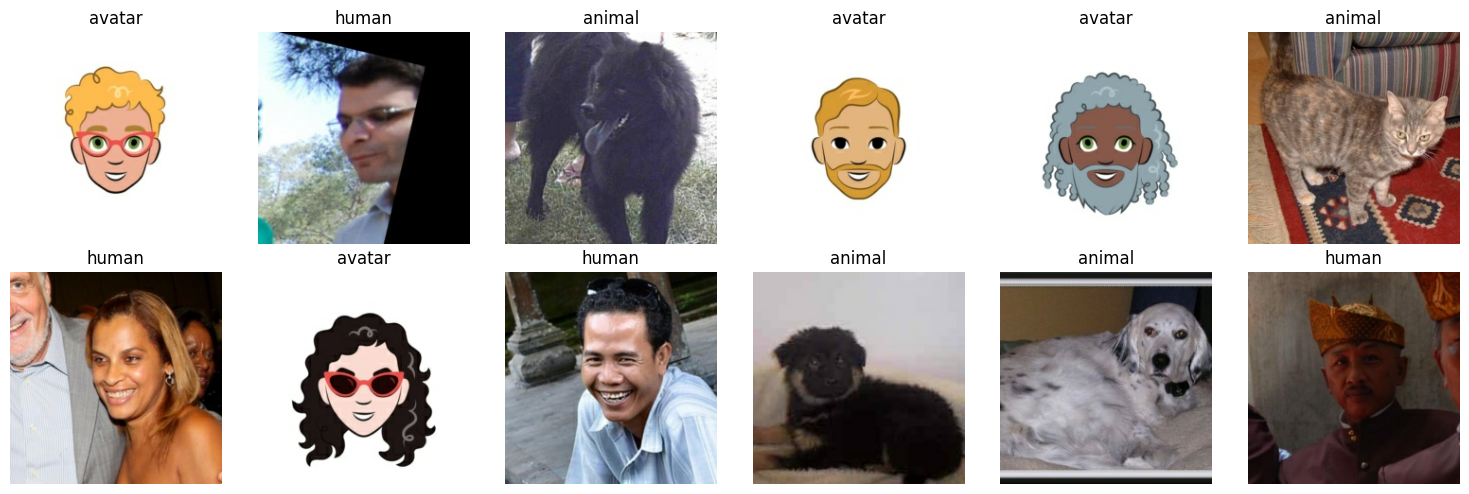

In [109]:
def show_samples(paths, labels, k=12, cols=6, seed=SEED):
    rng = np.random.default_rng(seed)
    if len(paths) == 0:
        print("No images found.")
        return
    idxs = rng.choice(len(paths), size=min(k, len(paths)), replace=False)
    sel_paths = paths[idxs]
    sel_labels = labels[idxs]

    rows = math.ceil(len(sel_paths) / cols)
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i, (p, lab) in enumerate(zip(sel_paths, sel_labels)):
        img = tf.io.read_file(p)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = resize_if_needed(img, IMG_SIZE)
        img = tf.cast(img, tf.uint8)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img.numpy())
        ax.set_title(CLASS_NAMES[lab])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_paths, train_labels, k=12, cols=6)

## Build datasets (tf.data with caching & prefetch)

This cell constructs TensorFlow **tf.data** datasets that perform ok for the train, validation, and test splits on my PC. It includes steps for decoding and resizing images, shuffling the training data, caching the datasets for faster access during training, batching the data, and prefetching batches for improved performance.

(see:
[Geeks for Geeks - Difference Between Dataset.from_tensors and Dataset.from_tensor_slices](https://www.geeksforgeeks.org/python/difference-between-dataset-from_tensors-and-dataset-from_tensor_slices/)
and [TensorFlow - tf.data performance guide](https://www.tensorflow.org/guide/data_performance))

In [110]:
AUTOTUNE = tf.data.AUTOTUNE

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = resize_if_needed(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

def make_dataset(paths, labels, batch_size, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=min(10000, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

ds_train = make_dataset(train_paths, train_labels, BATCH_SIZE, training=True)
ds_val   = make_dataset(val_paths,   val_labels,   BATCH_SIZE, training=False)
ds_test  = make_dataset(test_paths,  test_labels,  BATCH_SIZE, training=False)

len_train_steps = int(np.ceil(len(train_paths) / BATCH_SIZE))
len_val_steps   = int(np.ceil(len(val_paths)   / BATCH_SIZE))
len_test_steps  = int(np.ceil(len(test_paths)  / BATCH_SIZE))

print("Steps — train/val/test:", len_train_steps, len_val_steps, len_test_steps)

Steps — train/val/test: 750 94 94


## Build the model (ResNet50 backbone + custom head)

This cell constructs the CNN model using transfer learning with a pre-trained ResNet50 backbone from Keras Applications. It adds a data augmentation layer, the ResNet50 base (frozen), global average pooling, dropout layers for regularization, and a dense output layer for classification. The model is then compiled with an Adam optimizer and sparse categorical crossentropy loss.
* Augmentation layer - An augmentation layer is a Keras preprocessing layer that applies random, label-preserving transforms (e.g., flips, rotations, color jitter) to images during training to synthetically expand data diversity and reduce overfitting. (see: [Tensorflow - Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers?utm_source=chatgpt.com))
* Global average pooling - Replaces the “flatten → big dense layer” stack at the end of a CNN with a single operation that averages each feature map over its spatial dimensions. (see: [Learning Deep Features for Discriminative Localization](https://arxiv.org/pdf/1512.04150))
(see: [TensorFlow - Keras ResNet50 API docs](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) and [Keras Applications overview](https://keras.io/api/applications/))
* Dropout - The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.  (see: [Tensorflow - tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout))
* Adam - Fast, stable convergence with little tuning, it’s memory-efficient(see: [Adam optimizer](https://arxiv.org/abs/1412.6980))

In [111]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.20),
    layers.RandomBrightness(0.20),  # TF 2.13+
], name="data_augmentation")

base = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
)

base.trainable = False  # freeze backbone for initial training

inputs = keras.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32, name="image")
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs, name="resnet50_profilepic_classifier")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "resnet50_profilepic_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 224, 224,  │          0 │ get_item_18[0][0… │
│                     │ 3)                │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 224, 224,  │          0 │ stack_6[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_6[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 2048)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │        771 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compute class weights to mitigate imbalance

This cell calculates class weights using **sklearn.utils.class_weight.compute_class_weight**. Class weights are used during training to give more importance to underrepresented classes, helping to mitigate potential bias and improve performance on imbalanced datasets. I am doing this for good practice and more as a sanity check. There has already been significant effort in balancing the classes.

(see: [Scikit-learn - compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html))

In [112]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(CLASS_NAMES)),
    y=train_labels
)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


## Train (frozen backbone) — custom WEIGHTS checkpoint

This cell trains the model with the ResNet50 backbone frozen. It uses custom callbacks for early stopping, learning rate reduction, and saving the best model weights based on validation loss. The training history is also saved to a JSON file.

The SaveBest callback is used to save the model's weights only when a specific monitored metric (in this case, val_loss) improves during training.

(see:
[TensorFlow - Module: tf.keras.callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks),
[Keras - ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/?utm_source=chatgpt.com),
[Keras - Early Stopping](https://keras.io/api/callbacks/early_stopping/),
[Keras - ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/))

In [113]:
class SaveBest(keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if value is None:
            return
        improved = (value < self.best) if self.mode == 'min' else (value > self.best)
        if improved:
            self.best = value
            print(f"Saved improved weights to {self.filepath} (epoch {epoch+1}, {self.monitor}={value:.5f})")

def _jsonable_history(hdict):
    out = {}
    for k, v in hdict.items():
        try:
            out[k] = [float(x) for x in v]
        except Exception:
            out[k] = v
    return out

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    SaveBest("resnet50_best.weights.h5", monitor="val_loss", mode="min"),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9721 - loss: 0.0734Saved improved weights to resnet50_best.weights.h5 (epoch 1, val_loss=0.00203)
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9721 - loss: 0.0733 - val_accuracy: 0.9993 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 2/15
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9992 - loss: 0.0028Saved improved weights to resnet50_best.weights.h5 (epoch 2, val_loss=0.00086)
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9993 - val_loss: 8.6327e-04 - learning_rate: 1.0000e-04
Epoch 3/15
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9995 - loss: 0.0016Saved improved weights to resnet50_best.weights.h5 (epoch 3, val_loss=0.00033)
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 3.3280e-04 - learning_rate: 1.0000e-04
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - 

## Plot learning curves

Visualize training results. Note, we are using frozen base layers. We could unfreeze and fine-tune but it doesn't look like it's needed.

Made some tweaks. Return to the to make sure it worked.

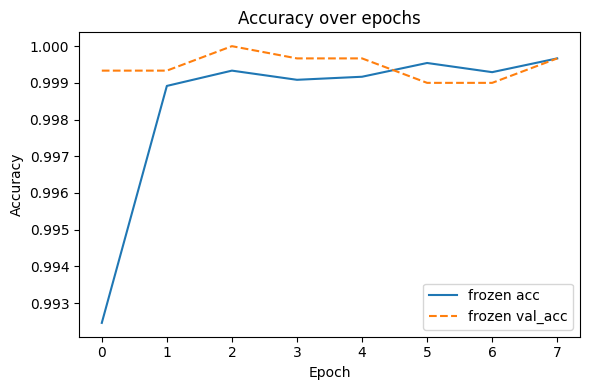

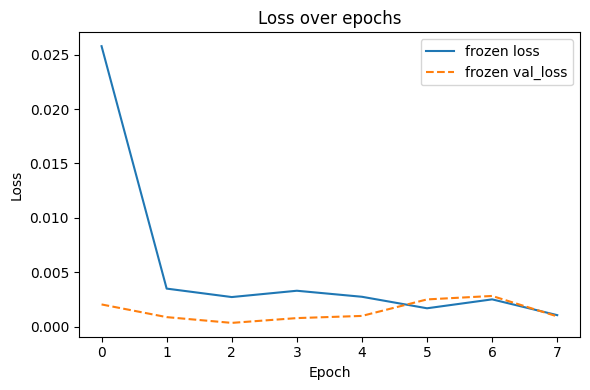

In [114]:
def plot_curves(histories, labels):
    plt.figure(figsize=(6,4))
    for h, lab in zip(histories, labels):
        plt.plot(h.get("accuracy", []), label=f"{lab} acc")
    for h, lab in zip(histories, labels):
        plt.plot(h.get("val_accuracy", []), linestyle="--", label=f"{lab} val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    for h, lab in zip(histories, labels):
        plt.plot(h.get("loss", []), label=f"{lab} loss")
    for h, lab in zip(histories, labels):
        plt.plot(h.get("val_loss", []), linestyle="--", label=f"{lab} val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves([history.history], ["frozen"])

## Evaluate on the test set

This cell evaluates the trained model on the unseen test set to assess its performance on new data. It calculates and prints the test loss and accuracy, generates a classification report showing precision, recall, and F1-score for each class, and computes the confusion matrix.

In [115]:
test_metrics = model.evaluate(ds_test, return_dict=True, verbose=1)
print("Test metrics:", test_metrics)

# Collect predictions and true labels
y_true = []
y_prob = []
for batch_imgs, batch_lbls in ds_test:
    probs = model.predict(batch_imgs, verbose=0)
    y_prob.append(probs)
    y_true.append(batch_lbls.numpy())

y_prob = np.concatenate(y_prob, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
print("Confusion matrix:\n", cm)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9999 - loss: 0.0018
Test metrics: {'accuracy': 0.999666690826416, 'loss': 0.0046241553500294685}

Classification report:
              precision    recall  f1-score   support

       human     0.9990    1.0000    0.9995      1000
      avatar     1.0000    1.0000    1.0000      1000
      animal     1.0000    0.9990    0.9995      1000

    accuracy                         0.9997      3000
   macro avg     0.9997    0.9997    0.9997      3000
weighted avg     0.9997    0.9997    0.9997      3000

Confusion matrix:
 [[1000    0    0]
 [   0 1000    0]
 [   1    0  999]]


## Plot confusion matrix

This cell defines a function to visualize the confusion matrix as a heatmap using Matplotlib. The confusion matrix provides a detailed breakdown of the model's predictions versus the true labels, helping to understand where the model is making errors.

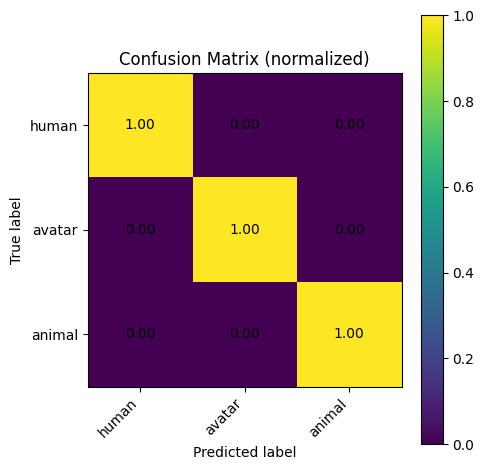

In [116]:
def plot_confusion_matrix(cm, class_names, normalize=True):
    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1e-12)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion Matrix' + (' (normalized)' if normalize else ''))
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, CLASS_NAMES, normalize=True)

## Image gallery: true label, prediction , class probabilities

This cell defines a function to display a gallery of 24 random test images along with their true labels, predicted labels (in bold), and the per-class prediction probabilities. This visual inspection helps to understand the model's performance on individual examples.

Saved gallery to test_predictions_gallery.png


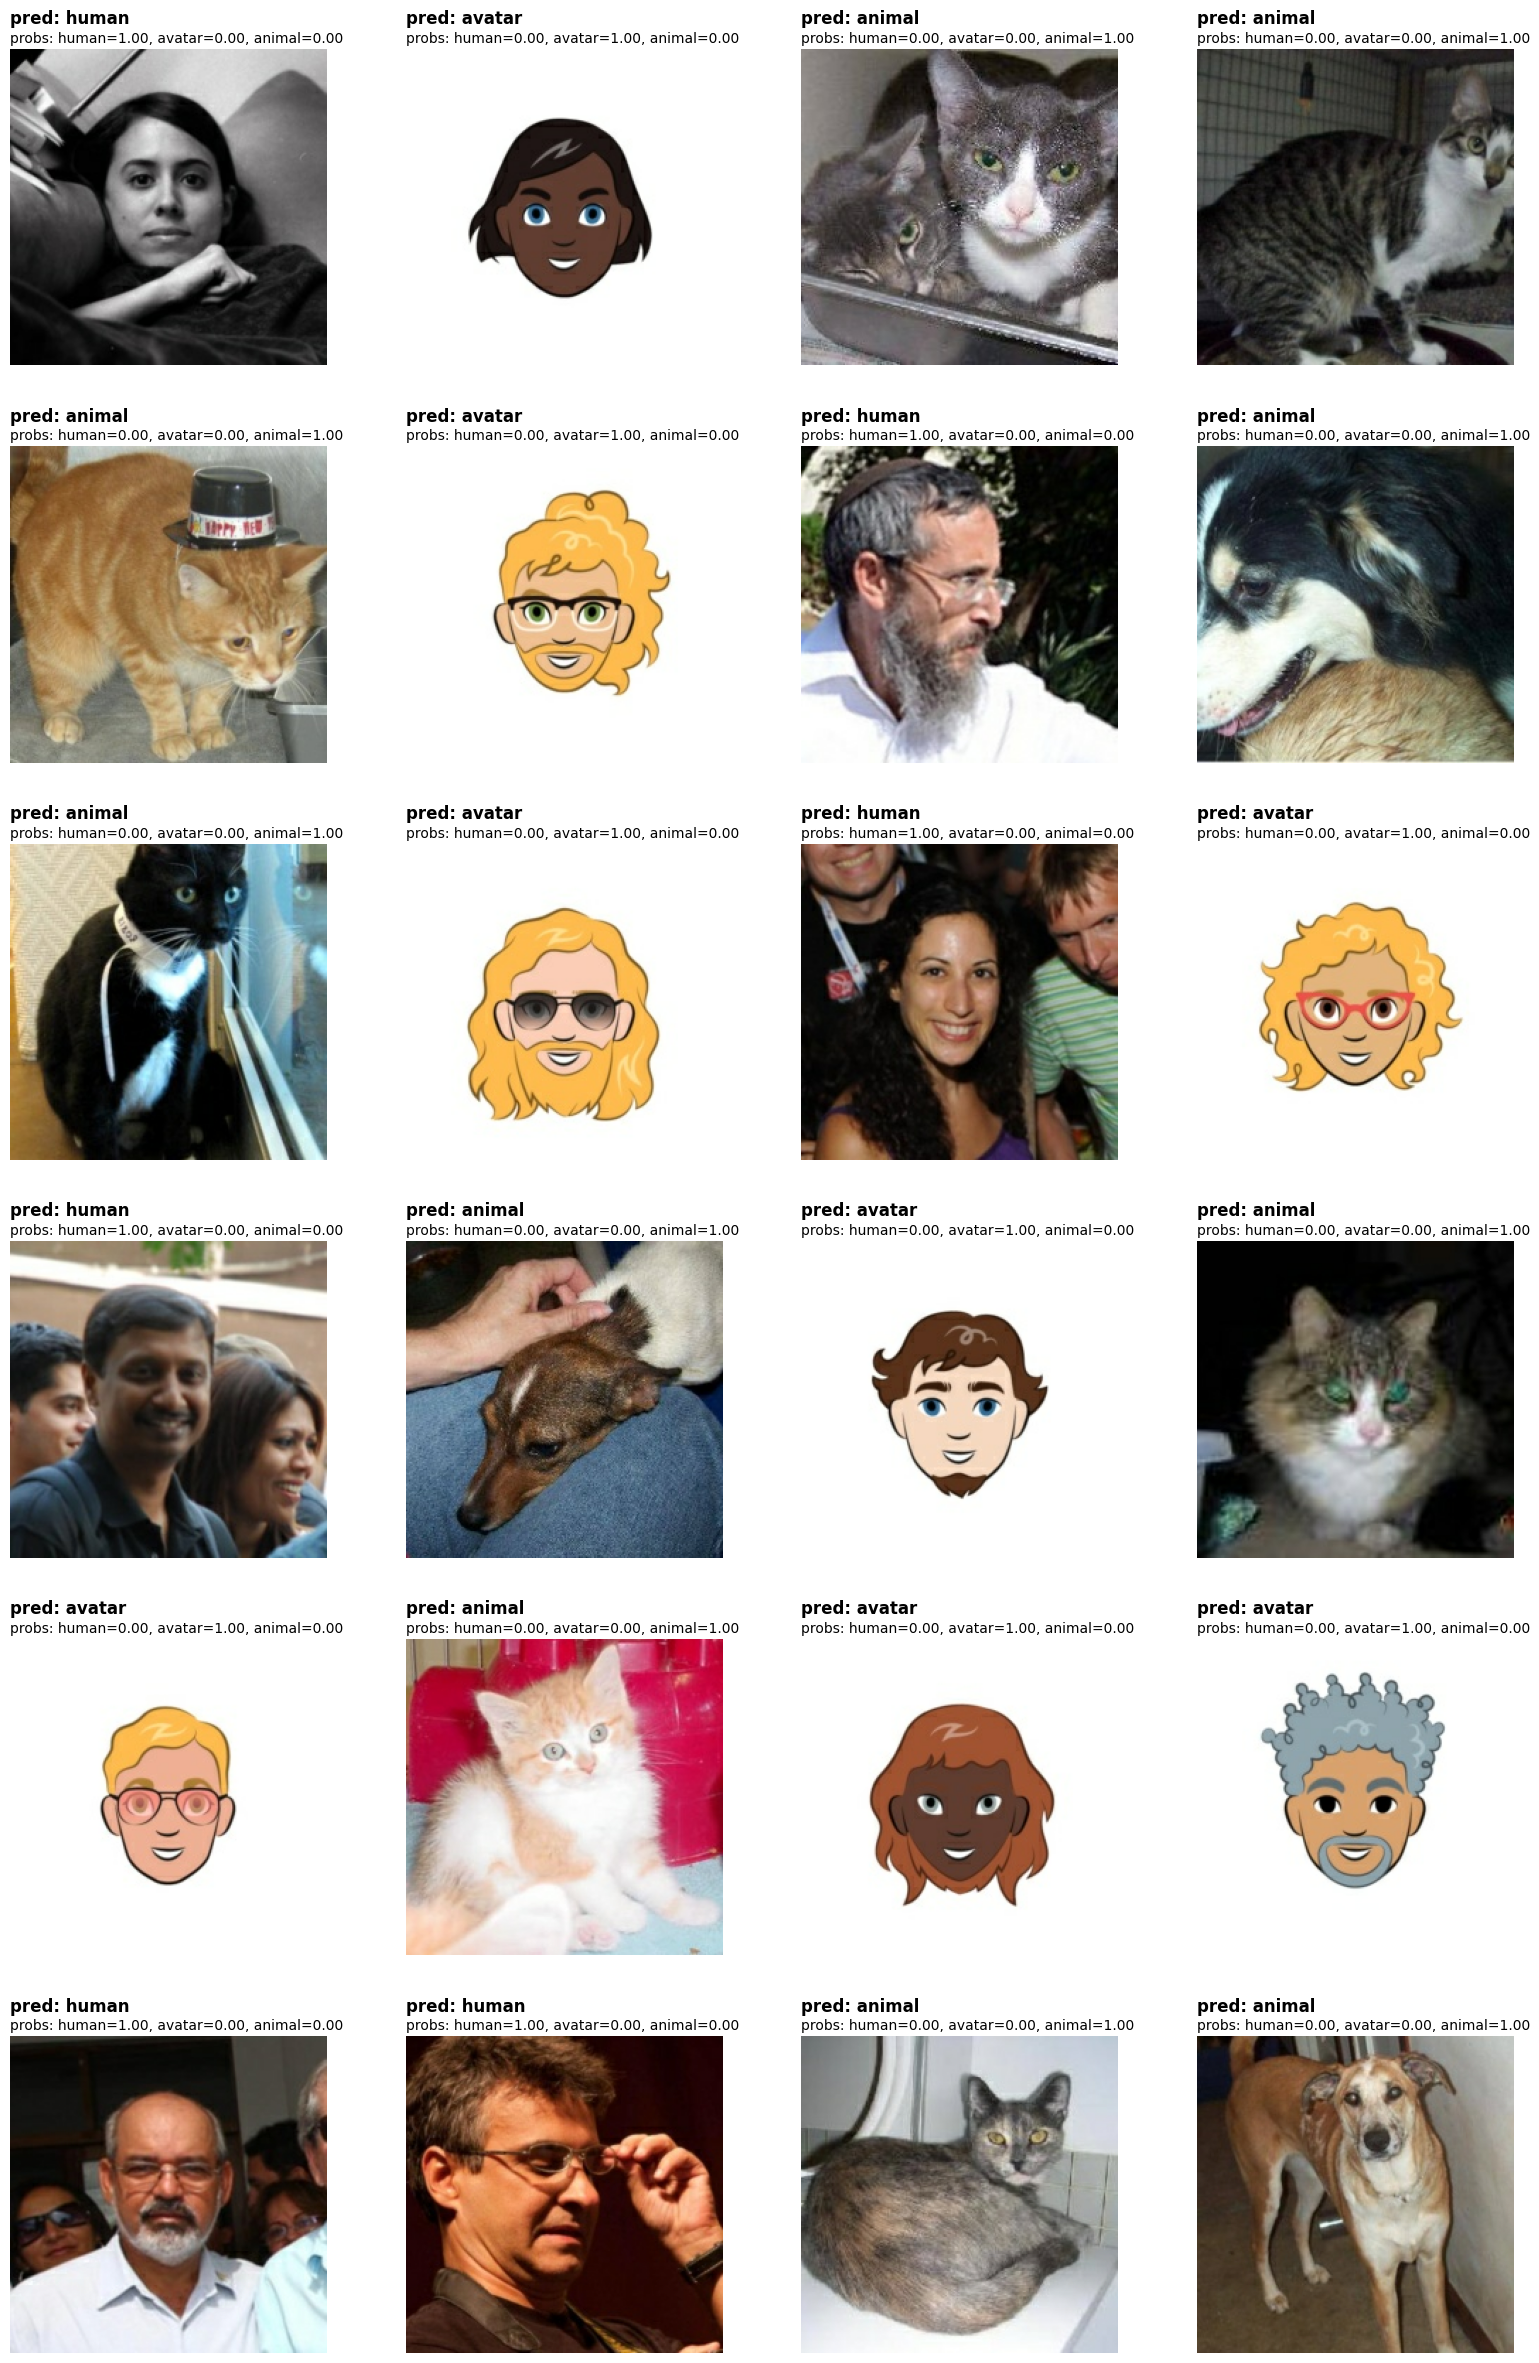

In [117]:
def show_predictions_gallery(paths, labels, k=24, cols=4, save_figure="test_predictions_gallery.png"):
    rng = np.random.default_rng(SEED)
    if len(paths) == 0:
        print("No test images to display.")
        return
    idxs = rng.choice(len(paths), size=min(k, len(paths)), replace=False)
    sel_paths = paths[idxs]
    sel_labels = labels[idxs]

    imgs = []
    for p in sel_paths:
        b = tf.io.read_file(p)
        b = tf.io.decode_image(b, channels=3, expand_animations=False)
        b = resize_if_needed(b, IMG_SIZE)
        imgs.append(b.numpy())
    imgs_arr = np.stack(imgs, axis=0).astype("float32")

    pred_probs = model.predict(imgs_arr, verbose=0)
    preds = np.argmax(pred_probs, axis=1)

    rows = math.ceil(len(sel_paths) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = np.array(axes).reshape(rows, cols)

    for i in range(rows*cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.axis("off")
        if i >= len(sel_paths):
            continue

        img = imgs_arr[i].astype("uint8")
        ax.imshow(img)

        true_lab = CLASS_NAMES[sel_labels[i]]
        pred_lab = CLASS_NAMES[preds[i]]
        probs = pred_probs[i]
        lines = [
            f"true: {true_lab}",
            f"pred: {pred_lab}",
            "probs: " + ", ".join([f"{CLASS_NAMES[j]}={probs[j]:.2f}" for j in range(len(CLASS_NAMES))])
        ]
        ax.set_title(lines[0], loc="left")
        ax.set_title(lines[1], loc="left", fontweight="bold", pad=18)
        ax.text(0.0, 1.01, lines[2], transform=ax.transAxes, va="bottom", ha="left") # Adjusted y coordinate

    plt.tight_layout()
    if save_figure:
        plt.savefig(save_figure, dpi=160, bbox_inches="tight")
        print(f"Saved gallery to {save_figure}")
    plt.show()

show_predictions_gallery(test_paths, test_labels, k=24, cols=4, save_figure="test_predictions_gallery.png")

## Notebook runtime summary (start, end, elapsed)
This cell calculates and prints the total time taken to run the notebook. This is helpful for tracking the duration of experiments and optimizing code for faster execution.

In [118]:
from datetime import datetime
RUN_END_DT = datetime.now()
RUN_END_T = time.perf_counter()

elapsed_seconds = RUN_END_T - RUN_START_T
def _fmt_hms(seconds: float) -> str:
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds - hours*3600 - minutes*60
    return f"{hours}:{minutes:02d}:{secs:06.3f}"

print("Notebook start time:", RUN_START_DT.strftime("%Y-%m-%d %H:%M:%S"))
print("Notebook end time:  ", RUN_END_DT.strftime("%Y-%m-%d %H:%M:%S"))
print("Elapsed (H:MM:SS):  ", _fmt_hms(elapsed_seconds))

Notebook start time: 2025-09-01 19:19:41
Notebook end time:   2025-09-01 19:23:27
Elapsed (H:MM:SS):   0:03:46.000
